In [1]:
from settings import *

##### Set global constants for this experiment

In [2]:
delta_t = 0.1
N = 4
L = 100


##### Load observables

In [3]:
Os = all_observables(m=m)
jump_oper_decay = default_jump_operators(m=m, gammas=gammas)
jump_oper_no_decay = no_decay_jump_operators()

##### Make training data

In [4]:
rho0s = random_rho0s(m=m, L=L)
rhoss, ts = solve_lindblad_rho0s(rho0s=rho0s, delta_t=delta_t, N=N, s=system, jump_opers=jump_oper_decay)
training_data = mk_training_data(rhoss=rhoss, Os=Os)

random_rho0s: setting seed=46098


##### Create a qubit layout and a parametrized circuit on those qubits

In [5]:
qubits = TriangularLayoutAB(m=m, distance=0.9)
circuit = HEA_fac(qubits, depth=10)

<Axes: title={'center': 'Qubit layout'}>

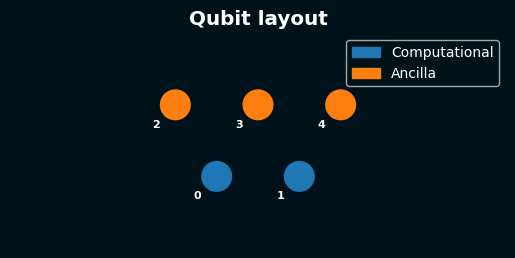

In [6]:
qubits.show_layout()

In [7]:
# optionally load already optimized theta

theta_opt = np.load("both_theta_opt.npy")

In [8]:
circuit.P

160

##### Optimize the parameters

In [9]:
theta_opt, errors, thetas = optimize(
    circuit=circuit,
    training_data=training_data,
    n_grad=10,
    max_count=200,
)

# optionally, save the results of the optimization process

theta_opt = np.save("both_theta_opt.npy", theta_opt)
thetas = np.save("both_thetas.npy", thetas)
errors = np.save("both_errors.npy", errors)

optimizer (optimization indices): setting seed=32465


C:\BFP\quantum-channel-approximation\q_channel_approx\optimizer.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  errors[i] = error


-----
        Grad calculation time: 
        247.60738730430603 
        Armijo calculation time: 
        30.643757343292236 
        Total grad descend time: 
        4:38.25


In [10]:
theta_opt = np.load("both_theta_opt.npy")
thetas = np.load("both_thetas.npy")
errors = np.load("both_errors.npy")

Text(0, 0.5, 'error')

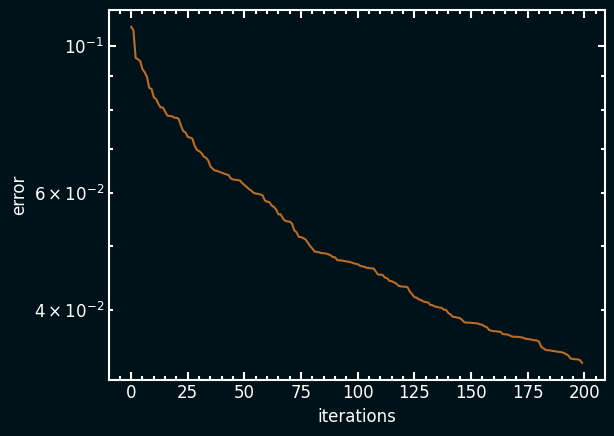

In [11]:
plt.semilogy(np.arange(len(errors)), errors)
plt.xlabel("iterations")
plt.ylabel("error")

##### Plot approximated solution compared to reference solution

In [12]:
n_time_steps = 50

rho0 = rho_rand_haar(m=m, seed=5502)

Os_comp = [O.full() for O in create_observables_comp_basis(m=m)]

In [13]:
# calculate reference solution

rhos_ref, ts = solve_lindblad_rho0(rho0, 
                                delta_t=delta_t, 
                                N=n_time_steps, 
                                s=system, 
                                jump_opers=jump_oper_decay,
                                )
Ess_ref = measure_rhos([r.full() for r in rhos_ref], Os_comp)

# calculate approximated solution

evolver = evolver_fac(circuit, theta_opt)
rhos_approx = evolver(n=n_time_steps, rho=rho0.full())
Ess_approx = measure_rhos(rhos_approx, Os_comp)

c:\BFP\quantum-channel-approximation\venv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\BFP\quantum-channel-approximation\venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


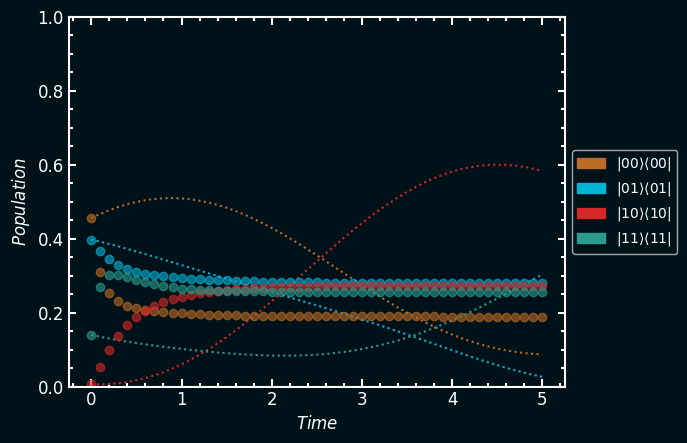

In [14]:
plot_ref(ts, Ess_ref)
plot_approx(ts, Ess_approx)

plt.ylabel("$Population$")
plt.xlabel("$Time$")
plt.ylim(0, 1)
plt.gca().legend(handles=legend_comp(m), loc="center left", bbox_to_anchor=(1, 0.5))

In [15]:
theta_opt

array([1.03636501, 1.06040729, 1.        , 1.        , 1.        ,
       1.1687702 , 1.05137089, 1.08317889, 1.08067134, 0.94016743,
       0.89068422, 1.00492202, 1.15308861, 0.89245992, 0.8979377 ,
       0.79095872, 1.03600235, 1.13859254, 0.99197563, 1.09357295,
       1.01543381, 0.91998568, 0.98215041, 0.95704057, 1.34189032,
       1.22580397, 0.94120032, 0.81952664, 0.78604024, 0.99401712,
       0.7081683 , 1.16292814, 0.96658334, 0.85204926, 0.79358506,
       0.39907615, 0.96338156, 0.80847725, 1.0192907 , 1.28289503,
       0.89755075, 1.15051361, 0.88217969, 0.95353867, 1.0474733 ,
       0.85637017, 0.95966344, 0.94141681, 0.97932652, 0.79869092,
       1.07082412, 0.8134355 , 1.15668802, 1.25796309, 1.27754965,
       0.93084292, 1.03455557, 0.98171387, 0.97061627, 1.00032102,
       0.99971681, 1.09809623, 0.97552189, 0.61129467, 0.82532538,
       0.74590932, 1.24094608, 0.81457188, 1.3758845 , 1.09273711,
       0.99802048, 1.17053623, 1.1961353 , 1.08380506, 1.14920